# **Install and/or import libraries:**

In [1]:
try:
    from mpi4py import MPI
except ImportError:
    !pip install mpi4py
    from mpi4py import MPI

try:
    import noise
except ImportError:
    !pip install noise
    import noise

import time
import numpy as np
from tqdm import tqdm
from numpy.fft import fftfreq, fft, ifft, fft2, ifft2, fftshift, ifftshift


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.6-cp310-cp310-linux_x86_64.whl size=2746296 sha256=2cac049b3827f2e43f1650918a55e51516aef40704d0255f87f5a065d1c000b2
  Stored in directory: /root/.cache/pip/wheels/4c/ca/89/8fc1fb1c620afca13bb41c630b1f948bbf446e0aaa4b762e10
Successfully built mpi4py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl size=56277 sha256=51af9fcecd2c3eac90862913c1db3a746306039258e214c2607856a3361898b3
  Stored in directory: /root/.cache/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


# **Simulation:**

## Functions:

In [28]:
def IC_coor(Nx, Ny, Np, dx, dy, rank, num_processes):
    '''
    Initialize physical and fourier space coordinates
    '''
    x = np.zeros((Np, Ny), dtype=float);
    y = np.zeros((Np, Ny), dtype=float);
    kx = np.zeros((Nx, Np), dtype=float);
    ky = np.zeros((Nx, Np), dtype=float);

    for j in range(Ny):
        x[0:Np, j] = range(Np);
        if num_processes == 1:
            x[0:Nx, j] = range(int(-Nx / 2), int(Nx / 2))

    if num_processes != 1:
        x = x - (num_processes/2 - rank)*Np
    x = x*dx;

    for i in range(Np):
        y[i, 0:Ny] = range(int(-Ny / 2), int(Ny / 2))
    y = y * dy;

    for j in range(Np):
        kx[0:Nx, j] = range(int(-Nx / 2), int(Nx / 2))

    for i in range(Nx):
        ky[i, 0:Np] = range(Np);
        if num_processes == 1:
            ky[i, 0:Ny] = range(int(-Ny / 2), int(Ny / 2))

    if num_processes != 1:
        ky = ky - (num_processes / 2 - rank) * Np
    k2 = kx**2 + ky**2;

    for i in range(Nx):
        for j in range(Np):
            if (k2[i, j] == 0):
                k2[i, j] = 1e-5

    k2_inv = K2_inv = 1/np.where(k2 == 0, 1, k2).astype(float)

    return x, y, kx, ky, k2, k2_inv

def fftn_mpi(u, fu):
    '''
    Perform forward Fourier transform using MPI
    '''
    Uc_hatT[:] = fftshift(fft(ifftshift(u), axis=1))
    U_mpi[:] = np.rollaxis(Uc_hatT.reshape(Np, num_processes, Np), 1)
    comm.Alltoall([U_mpi, MPI.DOUBLE_COMPLEX], [fu, MPI.DOUBLE_COMPLEX])
    fu[:] = fftshift(fft(ifftshift(fu), axis=0))
    return fu

def ifftn_mpi(fu, u):
    '''
    Perform inverse Fourier transform using MPI
    '''
    Uc_hat[:] = ifftshift(ifft(fftshift(fu), axis=0))
    comm.Alltoall([Uc_hat, MPI.DOUBLE_COMPLEX], [U_mpi, MPI.DOUBLE_COMPLEX])
    Uc_hatT[:] = np.rollaxis(U_mpi, 1).reshape(Uc_hatT.shape)
    u[:] = ifftshift(ifft(fftshift(Uc_hatT), axis=1))
    return u

def IC_2D(Nx, Np, u, v, u_hat, v_hat, IC_type, omega, omega_hat, X, Y):
    '''
    This function initializes the velocity field in Fourier space based on the initial condition type
    '''
    if IC_type == 'random_vel':
        # Random velocity initial condition (for very high reynolds random noise is not stable!)
        u = np.random.rand(Np, Ny)
        v = np.random.rand(Np, Ny)

        u = u / np.max(u)
        v = v / np.max(v)

        u_hat = fftn_mpi(u, u_hat)
        v_hat = fftn_mpi(v, v_hat)

        omega_hat = 1j*(Kx*v_hat - Ky*u_hat)

    if IC_type == 'taylor_green':
        # Taylor-Green vortex initial condition (In two dimensions Taylor-Green is not stable without the addition of noise!)
        u = np.sin(X)*np.cos(Y)
        v = -np.cos(X)*np.sin(Y)

        u_hat = fftn_mpi(u, u_hat)
        v_hat = fftn_mpi(v, v_hat)
        omega_hat = 1j*(Kx*v_hat - Ky*u_hat);

    if IC_type == 'taylor_green_noise':
        # Taylor-Green vortex with added noise initial condition
        epsilon = 0.1

        u = np.sin(X)*np.cos(Y) + epsilon*np.random.rand(*u.shape)
        v = -np.cos(X)*np.sin(Y) + epsilon*np.random.rand(*v.shape)

        u_hat = fftn_mpi(u, u_hat)
        v_hat = fftn_mpi(v, v_hat)

        omega_hat = 1j*(Kx*v_hat - Ky*u_hat);

    if IC_type == 'perlin_noise':
        # Perlin noise CURL initial condition
        np.random.seed() #Maybe this isnt working for the noise library...

        scale = 1. #2.5
        octaves = 2 #2
        persistence = 0.5 #0.5
        lacunarity = 4.0 #2

        omega = np.zeros((Np, Ny))

        for i in range(Np):
            for j in range(Ny):
                omega[i, j] = noise.pnoise2(X[i, j]/scale,
                                            Y[i, j]/scale,
                                            octaves=octaves,
                                            persistence=persistence,
                                            lacunarity=lacunarity
                                            )

        omega_hat = (fftn_mpi(omega, omega_hat))

    return omega_hat


## Plot function:

In [32]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns
sns.set(style='dark')

def plot(P, u, v, U, curl, t, T, step, Nstep):
    '''
    Plotting function to visualize the simulation results
    '''
    cmap = plt.cm.jet

    data_list = [U, curl]
    titles = ['Velocity', 'Vorticity']

    fig, axs = plt.subplots(1, len(titles), figsize=(15, 7), dpi=100, num=1, clear=True) #Suggestion: dpi=200
    fig.suptitle(r'$\mathbf{Physical\ Time:}$ ' + f'{t:.2f}/{T}  |  ' + r'$\mathbf{Iteration:}$ ' + f'{step}/{Nstep}', fontsize=16)

    for ax, data, titulo in zip(axs, data_list, titles):

        vmin = data.min()
        vmax = data.max()
        norm = Normalize(vmin=vmin, vmax=vmax)

        ax.imshow(data, extent=[0, Lx, 0, Ly],
                  cmap=cmap, norm=norm, aspect='equal', interpolation='bilinear')

        ax.set_title(titulo, fontweight='bold', fontstyle='italic')
        ax.set_xlabel("X", fontweight='bold')
        ax.set_ylabel("Y", fontweight='bold')


        mappable = ScalarMappable(norm=norm, cmap=cmap) # Create a ScalarMappable for the colorbar for this subplot
        mappable.set_array(data)

    # Save and/or show the figure
    nome_tmp = 'plot_'+str(step)+'.png'
    plot_filenames.append(nome_tmp)
    plt.savefig('/content/'+nome_tmp)
    #plt.close(fig)
    plt.show()

#List to save plots:
plot_filenames = []


## Main Loop:

num_processes 1 rank 0


  0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-28-9bfe4f4f0c4e>:61: ComplexWarning: Casting complex values to real discards the imaginary part
  u[:] = ifftshift(ifft(fftshift(Uc_hatT), axis=1))
  0%|          | 0/2000 [00:26<?, ?it/s]


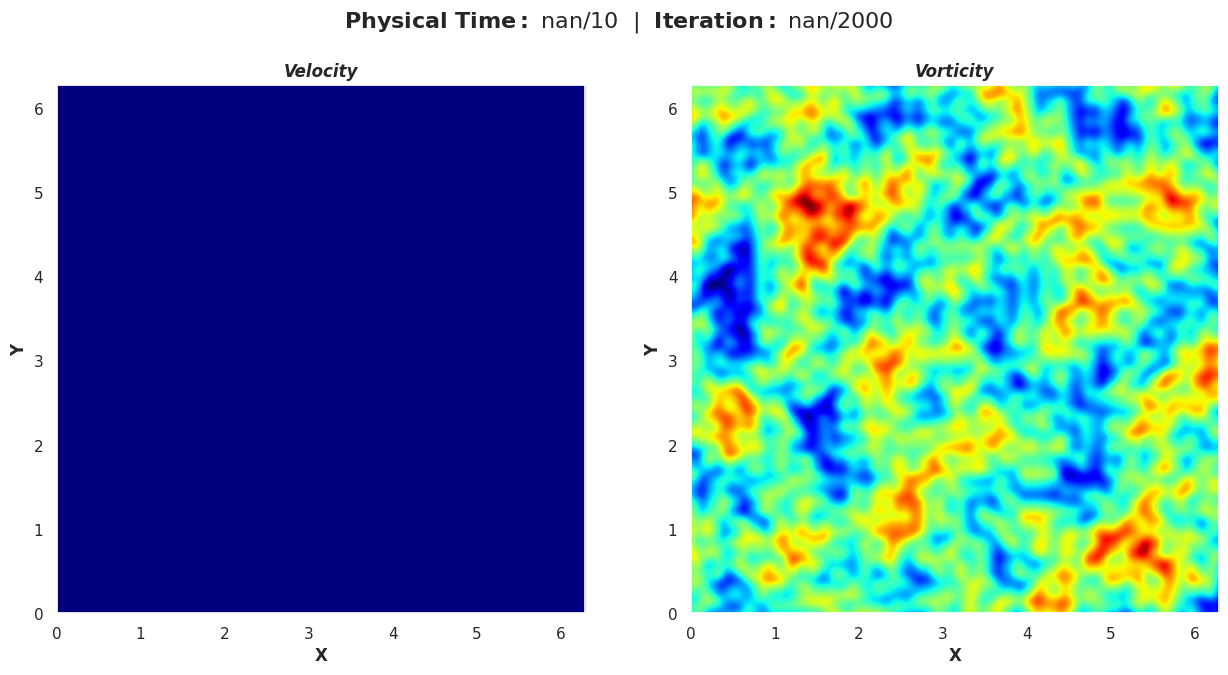

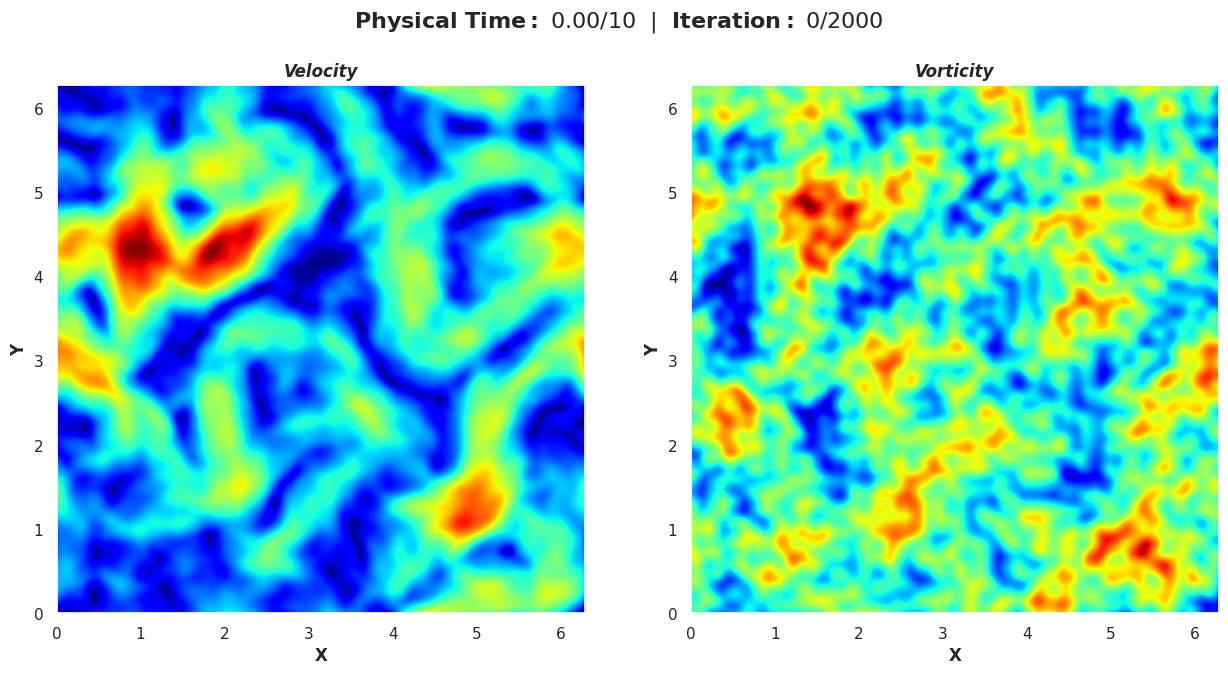

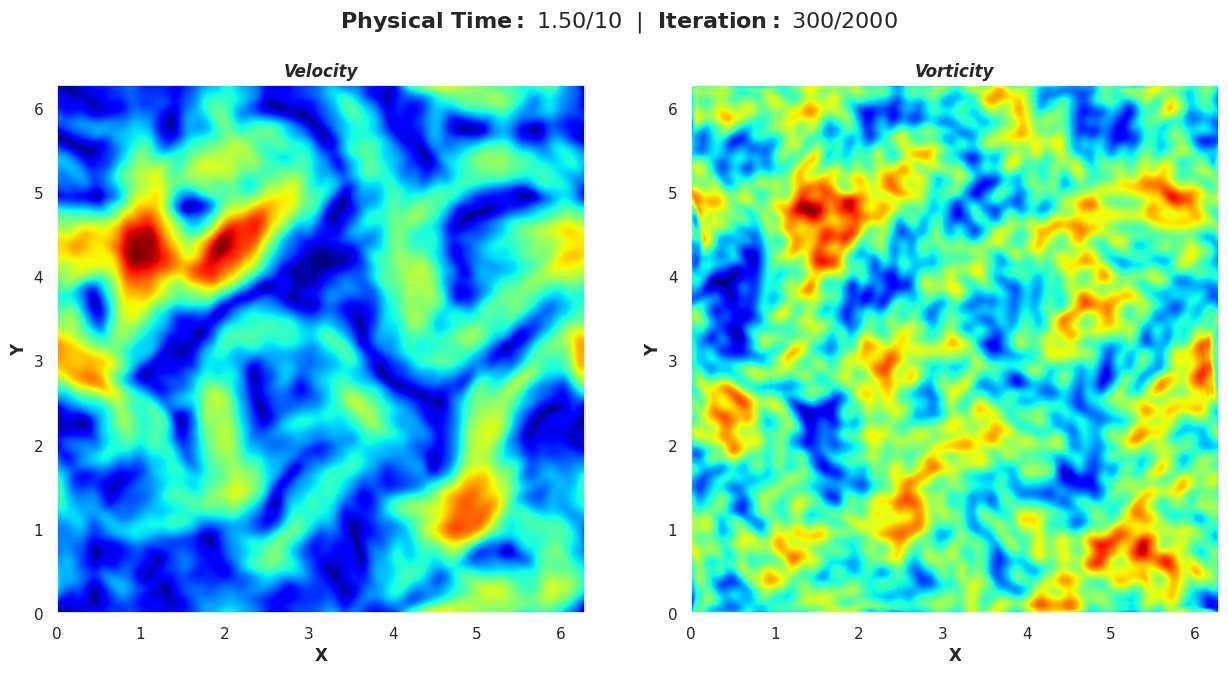

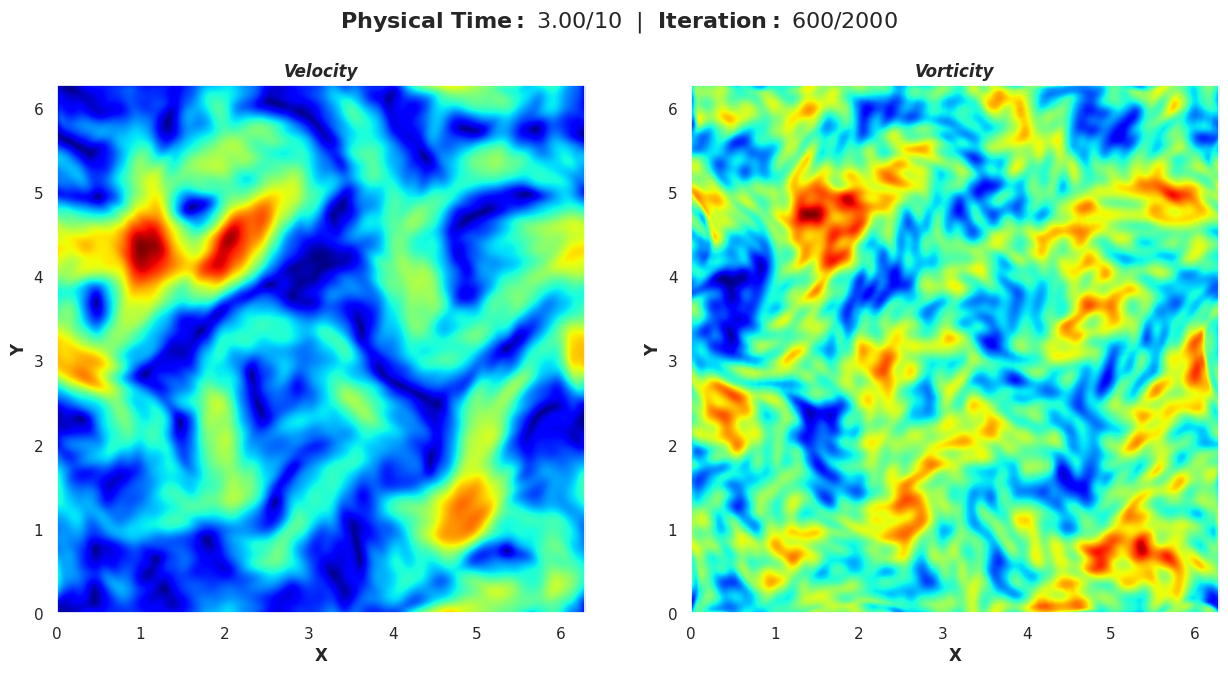

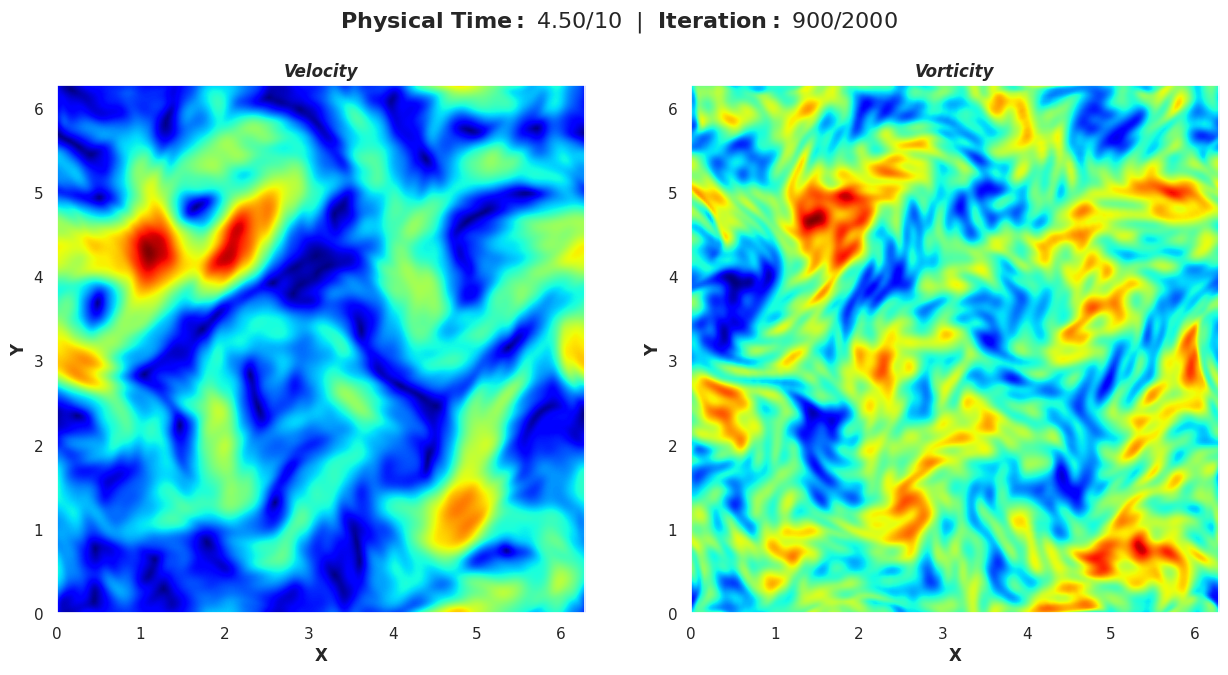

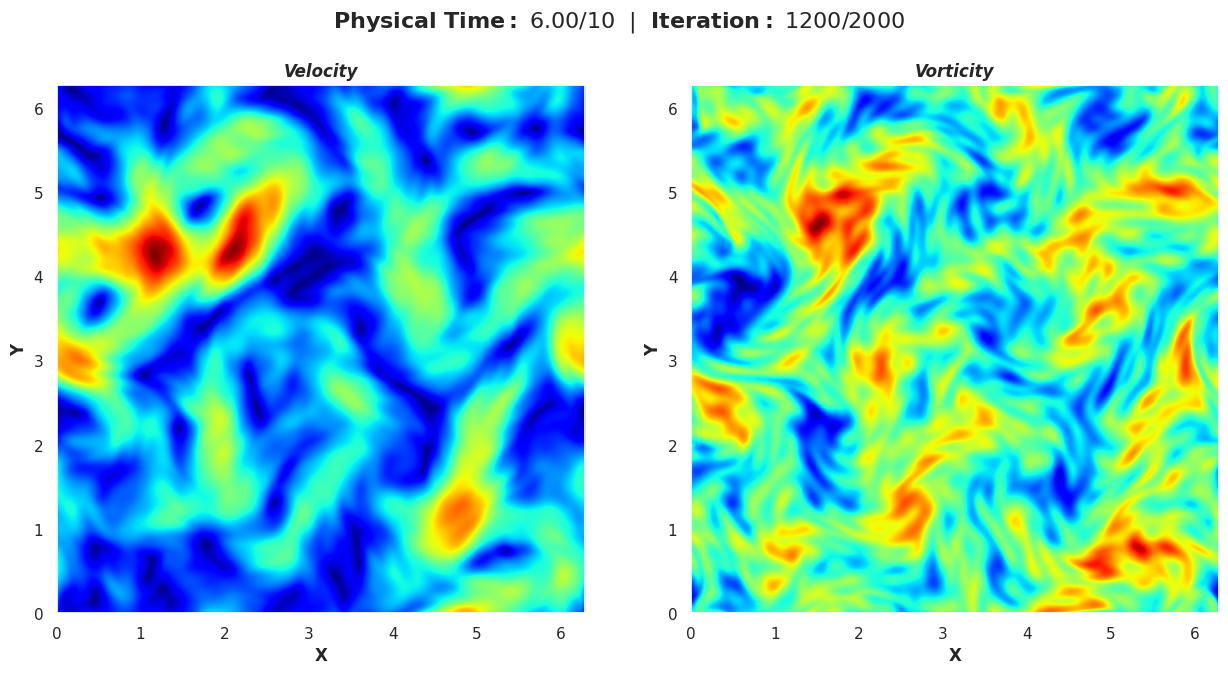

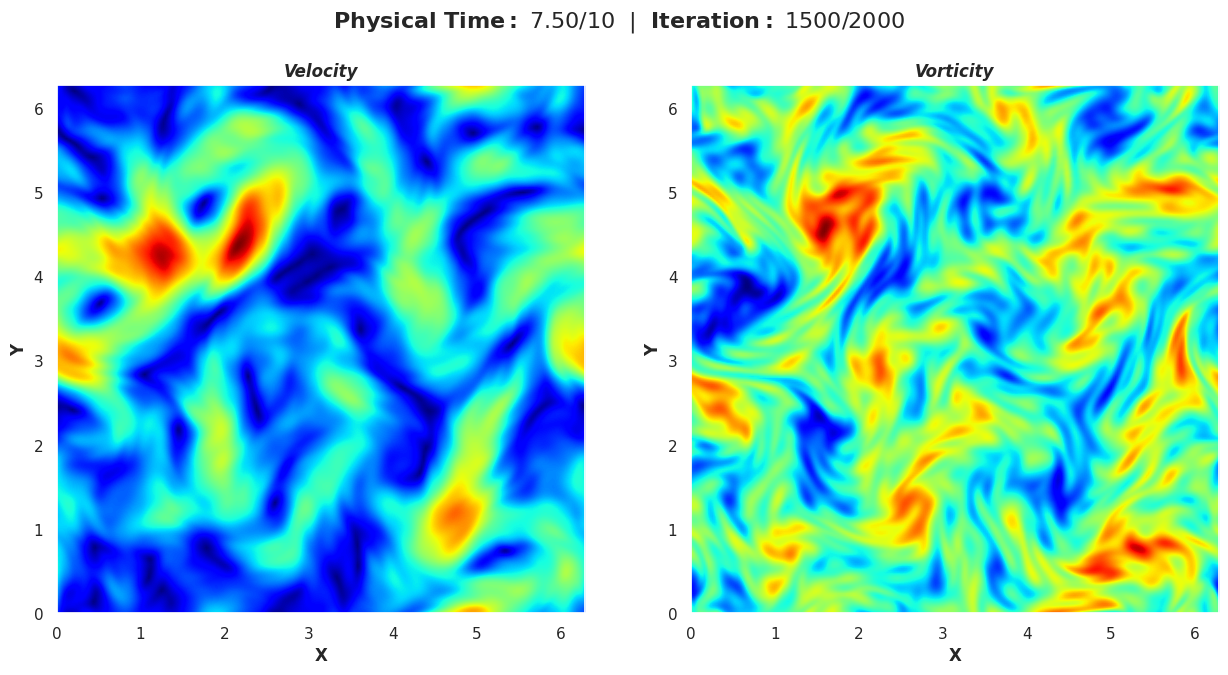

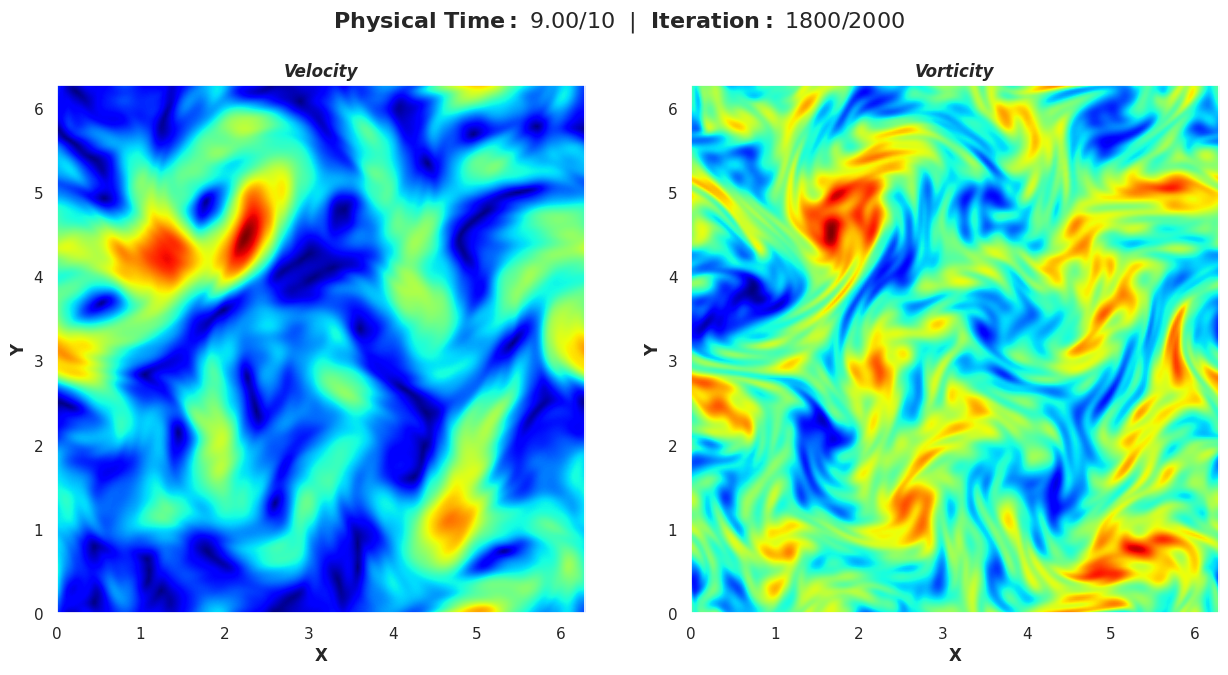

  0%|          | 0/2000 [00:55<?, ?it/s]


In [33]:
# SIMULATION PARAMETERS:
viscosity = 1/16000      # Viscosity = 1/Reynolds. Suggestion: Reynolds -> 1600 or 16000
t_f = 10 #300                # Final physical time
dt = 0.005               # Time step. Suggestion: 0.01, 0.001 or 0.005
N = Nx = Ny = 2**8       # Grid dimension
IC_type = 'perlin_noise' # Initial conditions. Check initial_conditions.py

# MPI SETUP:
comm = MPI.COMM_WORLD
num_processes = comm.Get_size()
rank = comm.Get_rank()
Np = int(N/num_processes) #Slab decomposition
print('num_processes', num_processes, 'rank', rank)

n_steps = int(np.ceil(t_f/dt)) #Number of frames in the simulation

# Spatial domain parameters
Lx = 2*np.pi;
Ly = 2*np.pi;
dx = Lx/Nx;
dy = Ly/Ny;

#Coordinates and wave numbers
x, y, Kx, Ky, K2, K2_inv = IC_coor(Nx, Ny, Np, dx, dy, rank, num_processes)
sx = slice(rank*Np,(rank+1)*Np)
Xmesh = np.mgrid[sx, :N].astype(float) * Lx / N
X = Xmesh[0]
Y = Xmesh[1]

Uc_hat = np.empty((N, Np), dtype=complex)
Uc_hatT = np.empty((Np, N), dtype=complex)
U_mpi = np.empty((num_processes, Np, Np), dtype=complex)

LapHat = K2.copy()
LapHat *= -1
K2 *=-1
K2_inv = 1 / np.where(K2 == 0, 1, K2).astype(float)
ikx_over_K2 = 1j * Kx * K2_inv
iky_over_K2 = 1j * Ky * K2_inv

# Define dealias:
kmax_dealias = 2./3.*(N/2 + 1)
dealias = np.array((abs(Kx) < kmax_dealias)*(abs(Ky) < kmax_dealias), dtype=bool)

# Preallocate arrays
u_hat = np.zeros((Nx, Np), dtype=complex)
v_hat = np.zeros((Nx, Np), dtype=complex)
u = np.zeros((Np, Ny), dtype=float)
v = np.zeros((Np, Ny), dtype=float)
omega_hat = np.zeros((Nx, Np), dtype=complex)
omega = np.zeros((Np, Ny), dtype=float)
omega_kx = np.zeros((Np, Ny), dtype=float)
omega_ky = np.zeros((Np, Ny), dtype=float)
v_grad_omega_hat = np.zeros((Ny, Np), dtype=complex)

# --- MAIN LOOP: ----
pbar = tqdm(total=int(n_steps))

# Initial vorticity field
omega_hat_t0 = IC_2D(Nx, Np, u, v, u_hat, v_hat, IC_type, omega, omega_hat, X, Y)
omega = ifftn_mpi(omega_hat_t0, omega)

# Plot the initial state of the simulation:
# Obs.: np.sqrt(u**2 + v**2) is the amplitude of the velocity and ifftn_mpi(omega_hat, omega) is the curl
plot(0, u, v, np.sqrt(u**2 + v**2), ifftn_mpi(omega_hat_t0, omega), float('NaN'), t_f, float('NaN'), n_steps)

for n in range(n_steps + 1):

    if n == 0: # Initialize vorticity field (for the simulation)
        omega_hat = omega_hat_t0

    # Compute velocity in Fourier space
    u_hat = -iky_over_K2*omega_hat
    v_hat = ikx_over_K2*omega_hat
    u = ifftn_mpi(u_hat, u)
    v = ifftn_mpi(v_hat, v)

    # Compute terms for vorticity equation
    omega_kx = ifftn_mpi(1j*Kx * omega_hat, omega_kx)
    omega_ky = ifftn_mpi(1j*Ky * omega_hat, omega_ky)
    v_grad_omega = (u * omega_kx + v * omega_ky)
    v_grad_omega_hat = fftn_mpi(v_grad_omega, v_grad_omega_hat)*dealias
    visc_term_complex = -viscosity * K2 * omega_hat

    # Compute new vorticity field
    omega_hat_new = 1/(1/dt - 0.5*viscosity*LapHat)*(
                (1/dt + 0.5*viscosity*LapHat)*omega_hat - v_grad_omega_hat);
    omega_hat = omega_hat_new.copy()

    # Plot/Save the vorticity field at intervals
    if n%300==0: #Suggestion: plot every 150 iterations to animate
        plot(0, u, v, np.sqrt(u**2 + v**2), ifftn_mpi(omega_hat, omega), n*dt, t_f, n, n_steps)

    #step += 1

    #pbar.update(1) #Comment this line if youre plotting with plt.show()

pbar.close()


# **Data Analysis:**

## Animations:

**Import/install libraries:**

In [34]:
try:
    import imageio
except ImportError:
    !pip install imageio
    import imageio


**.gif:**

In [35]:
with imageio.get_writer("animation_gif.gif", mode='I', duration=0.1) as writer:
    for filename in plot_filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


<ipython-input-35-d43ad52a0ed4>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


**.mp4:**

In [36]:
with imageio.get_writer("animation_video.mp4", fps=20, codec='libx264', quality=8) as writer:
    for filename in plot_filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


<ipython-input-36-d409a8e0add4>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


# **Old Version Backup:**

In [ ]:
try:
    from mpi4py import MPI
except ImportError:
    !pip install mpi4py
    from mpi4py import MPI

try:
    import noise
except ImportError:
    !pip install noise
    import noise

import time
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from tqdm import tqdm
from numpy.fft import fftfreq, fft, ifft, fft2, ifft2, fftshift, ifftshift

import seaborn as sns
sns.set(style='dark')

def IC_2D(Nx, Np, u, v, u_hat, v_hat, IC_type, omega, omega_hat, X, Y):
    '''
    This function initializes the velocity field in Fourier space based on the initial condition type
    '''
    if IC_type == 'random_vel':
        # Random velocity initial condition
        u = np.andom.rand(Np, Ny)
        v = np.random.rand(Np, Ny)

        u = u / np.npmax(u)
        v = v / np.npmax(v)

        u_hat = fftn_mpi(u, u_hat)
        v_hat = fftn_mpi(v, v_hat)

        omega_hat = 1j*(Kx*v_hat - Ky*u_hat)

    if IC_type == 'taylor_green':
        # Taylor-Green vortex initial condition
        u = np.sin(3*X)*np.cos(3*Y)
        v = -np.cos(3*X)*np.sin(3*Y)

        u_hat = fftn_mpi(u, u_hat)
        v_hat = fftn_mpi(v, v_hat)
        omega_hat = 1j*(Kx*v_hat - Ky*u_hat);

    if IC_type == 'taylor_green_noise':
        # Taylor-Green vortex with added noise initial condition
        epsilon = 0.1

        u = np.sin(X)*np.cos(Y) + epsilon*np.random.rand(*u.shape)
        v = -np.cos(X)*np.sin(Y) + epsilon*np.random.rand(*v.shape)

        u_hat = fftn_mpi(u, u_hat)
        v_hat = fftn_mpi(v, v_hat)

        omega_hat = 1j*(Kx*v_hat - Ky*u_hat);

    if IC_type == 'perlin_noise':
        # Perlin noise CURL initial condition
        np.random.seed() #Maybe this isnt working for the noise library...

        scale = 1. #2.5
        octaves = 2 #2
        persistence = 0.5 #0.5
        lacunarity = 4.0 #2

        omega = np.zeros((Np, Ny))

        for i in range(Np):
            for j in range(Ny):
                omega[i, j] = noise.pnoise2(X[i, j]/scale,
                                            Y[i, j]/scale,
                                            octaves=octaves,
                                            persistence=persistence,
                                            lacunarity=lacunarity
                                            )

        omega_hat = (fftn_mpi(omega, omega_hat))

    return omega_hat

def plot(P, u, v, U, curl, t, T, step, Nstep):
    '''
    Plotting function to visualize the simulation results
    '''
    cmap = plt.cm.jet

    data_list = [U, curl]  # Data to plot
    titles = ['Velocity', 'Vorticity']  # Titles for the plots

    fig, axs = plt.subplots(1, len(titles), figsize=(15, 7), dpi=100, num=1, clear=True) #Suggestion: dpi=200
    fig.suptitle(r'$\mathbf{Physical\ Time:}$ ' + f'{t:.2f}/{T}  |  ' + r'$\mathbf{Iteration:}$ ' + f'{step}/{Nstep}', fontsize=16)

    for ax, data, titulo in zip(axs, data_list, titles):
        # Normalization for the colorbar
        vmin = data.min()
        vmax = data.max()
        norm = Normalize(vmin=vmin, vmax=vmax)

        ax.imshow(data, extent=[0, Lx, 0, Ly],
                  cmap=cmap, norm=norm, aspect='equal', interpolation='bilinear')

        ax.set_title(titulo, fontweight='bold', fontstyle='italic')
        ax.set_xlabel("X", fontweight='bold')
        ax.set_ylabel("Y", fontweight='bold')

        # Create a ScalarMappable for the colorbar for this subplot
        mappable = ScalarMappable(norm=norm, cmap=cmap)
        mappable.set_array(data)

    # Save and/or show the figure
    nome_tmp = 'plot_'+str(step)+'.png'
    plot_filenames.append(nome_tmp)
    #plt.savefig('/content/'+nome_tmp)
    #plt.close(fig)
    #gc.collect()
    plt.show()

#List to save plots:
plot_filenames = []

#Initialize physical and fourier space coordinates
def IC_coor(Nx, Ny, Np, dx, dy, rank, num_processes):

    x = np.zeros((Np, Ny), dtype=float);
    y = np.zeros((Np, Ny), dtype=float);
    kx = np.zeros((Nx, Np), dtype=float);
    ky = np.zeros((Nx, Np), dtype=float);

    for j in range(Ny):
        x[0:Np, j] = range(Np);
        if num_processes == 1:
            x[0:Nx, j] = range(int(-Nx / 2), int(Nx / 2))

    if num_processes != 1:
        x = x - (num_processes/2 - rank)*Np

    x = x*dx;

    for i in range(Np):
        y[i, 0:Ny] = range(int(-Ny / 2), int(Ny / 2))

    y = y * dy;

    for j in range(Np):
        kx[0:Nx, j] = range(int(-Nx / 2), int(Nx / 2))

    for i in range(Nx):
        ky[i, 0:Np] = range(Np);

        if num_processes == 1:
            ky[i, 0:Ny] = range(int(-Ny / 2), int(Ny / 2))

    if num_processes != 1:
        ky = ky - (num_processes / 2 - rank) * Np

    k2 = kx**2 + ky**2;

    for i in range(Nx):
        for j in range(Np):
            if (k2[i, j] == 0):
                k2[i, j] = 1e-5

    # k2_exp = exp(-nu * (k2 ** 5) * dt - nu_hypo * dt);
    k2_inv = K2_inv = 1/np.where(k2 == 0, 1, k2).astype(float)

    return x, y, kx, ky, k2, k2_inv

def fftn_mpi(u, fu):
    # Perform forward Fourier transform using MPI
    Uc_hatT[:] = fftshift(fft(ifftshift(u), axis=1))
    U_mpi[:] = np.rollaxis(Uc_hatT.reshape(Np, num_processes, Np), 1)
    comm.Alltoall([U_mpi, MPI.DOUBLE_COMPLEX], [fu, MPI.DOUBLE_COMPLEX])
    fu[:] = fftshift(fft(ifftshift(fu), axis=0))
    return fu

def ifftn_mpi(fu, u):
    # Perform inverse Fourier transform using MPI
    Uc_hat[:] = ifftshift(ifft(fftshift(fu), axis=0))
    comm.Alltoall([Uc_hat, MPI.DOUBLE_COMPLEX], [U_mpi, MPI.DOUBLE_COMPLEX])
    Uc_hatT[:] = np.rollaxis(U_mpi, 1).reshape(Uc_hatT.shape)
    u[:] = ifftshift(ifft(fftshift(Uc_hatT), axis=1))
    return u

# SIMULATION PARAMETERS:
viscosity = 1/16000      # Viscosity = 1/Reynolds. Suggestion: Reynolds -> 1600 or 16000
t_f = 300                # Final physical time
dt = 0.005               # Time step. Suggestion: 0.01 or 0.001
N = Nx = Ny = 2**9       # Grid dimension
IC_type = 'perlin_noise' # Initial conditions. Check initial_conditions.py

# MPI SETUP:
comm = MPI.COMM_WORLD
num_processes = comm.Get_size()
rank = comm.Get_rank()
Np = int(N/num_processes) #Slab decomposition
print('num_processes', num_processes, 'rank', rank)

n_steps = int(np.ceil(t_f/dt)) #Number of frames in the simulatino

# Spatial domain parameters
Lx = 2*np.pi;
Ly = 2*np.pi;
dx = Lx/Nx;
dy = Ly/Ny;



#Coordinates and wave numbers
x, y, Kx, Ky, K2, K2_inv = IC_coor(Nx, Ny, Np, dx, dy, rank, num_processes)
sx = slice(rank*Np,(rank+1)*Np)
Xmesh = np.mgrid[sx, :N].astype(float) * Lx / N
X = Xmesh[0]
Y = Xmesh[1]



Uc_hat = np.empty((N, Np), dtype=complex)
Uc_hatT = np.empty((Np, N), dtype=complex)
U_mpi = np.empty((num_processes, Np, Np), dtype=complex)



#x = Y[0] #Is this really being used?
#y = Y[0] #Is this really being used?
#kx = fftfreq(N, 1./N)
#ky = kx.copy()
''' I dont know why this exists...
K = array(meshgrid(kx, ky[sx], indexing='ij'), dtype=int)
Kx = K[1]
Ky = K[0]
K2 = sum(K * K, 0, dtype=int)
'''
LapHat = K2.copy()
LapHat *= -1
#K2[0][0] = 1
K2 *=-1
K2_inv = 1 / np.where(K2 == 0, 1, K2).astype(float)
ikx_over_K2 = 1j * Kx * K2_inv
iky_over_K2 = 1j * Ky * K2_inv



# Define dealias:
kmax_dealias = 2./3.*(N/2 + 1)
dealias = np.array((abs(Kx) < kmax_dealias)*(abs(Ky) < kmax_dealias), dtype=bool)



# Preallocate arrays
u_hat = np.zeros((Nx, Np), dtype=complex)
v_hat = np.zeros((Nx, Np), dtype=complex)
u = np.zeros((Np, Ny), dtype=float)
v = np.zeros((Np, Ny), dtype=float)
#omega_hat0 = np.zeros((Nx, Np), dtype=complex)
#omega_hat1 = np.zeros((Nx, Np), dtype=complex)
omega_hat = np.zeros((Nx, Np), dtype=complex)
#omega_hat_new = np.zeros((Nx, Np), dtype=complex)
omega = np.zeros((Np, Ny), dtype=float)
omega_kx = np.zeros((Np, Ny), dtype=float)
omega_ky = np.zeros((Np, Ny), dtype=float)
#v_grad_omega = np.zeros((Np, Ny), dtype=float)
#psi_hat = np.zeros((Nx, Np), dtype=complex)
#rhs_hat = np.zeros((Nx, Np), dtype=complex)
#rhs = np.zeros((Np, Nx), dtype=float)
#visc_term_complex = np.zeros((Ny, Np), dtype=complex)
#visc_term_real = np.zeros((Np, Ny), dtype=float)
v_grad_omega_hat = np.zeros((Ny, Np), dtype=complex)
#u_storage_init = np.empty((1, Nx, Nx), dtype=float)
#v_storage_init = np.empty((1, Nx, Nx), dtype=float)
#omega_storage_init = np.empty((1, Nx, Nx), dtype=float)
'''
a = [1. / 6., 1. / 3., 1. / 3., 1. / 6.]
b = [0.5, 0.5, 1.]
'''

# --- MAIN LOOP: ----
step = 1                                                  #Substituit isso por n
pbar = tqdm(total=int(n_steps))

# Initial vorticity field
omega_hat_t0 = IC_2D(Nx, Np, u, v, u_hat, v_hat, IC_type, omega, omega_hat, X, Y)
omega = ifftn_mpi(omega_hat_t0, omega)

# Plot the initial state of the simulation:
# Obs.: np.sqrt(u**2 + v**2) is the amplitude of the velocity and ifftn_mpi(omega_hat, omega) is the curl
plot(0, u, v, np.sqrt(u**2 + v**2), ifftn_mpi(omega_hat, omega), 0, t_f, step, n_steps)

for n in range(n_steps + 1):

    if n == 0: # Initialize vorticity field (for the simulation)
        omega_hat = omega_hat_t0

    # Compute velocity in Fourier space
    u_hat = -iky_over_K2*omega_hat
    v_hat = ikx_over_K2*omega_hat
    u = ifftn_mpi(u_hat, u)
    v = ifftn_mpi(v_hat, v)

    # Compute terms for vorticity equation
    omega_kx = ifftn_mpi(1j*Kx * omega_hat, omega_kx)
    omega_ky = ifftn_mpi(1j*Ky * omega_hat, omega_ky)
    v_grad_omega = (u * omega_kx + v * omega_ky)
    v_grad_omega_hat = fftn_mpi(v_grad_omega, v_grad_omega_hat)*dealias
    visc_term_complex = -viscosity * K2 * omega_hat

    # Compute new vorticity field
    omega_hat_new = 1/(1/dt - 0.5*viscosity*LapHat)*(
                (1/dt + 0.5*viscosity*LapHat)*omega_hat - v_grad_omega_hat);
    omega_hat = omega_hat_new.copy()

    # Plot/Save the vorticity field at intervals
    if step%50==0: #Suggestions: 150
        plot(0, u, v, np.sqrt(u**2 + v**2), ifftn_mpi(omega_hat, omega), n*dt, t_f, step, n_steps)

    step += 1

    pbar.update(1)

pbar.close()
